In [3]:
import pandas as pd
from scipy import optimize as opt
import numpy as np
from IPython.display import display
import autograd.numpy as au
from autograd import grad, jacobian
from scipy.optimize import line_search
from matplotlib import pyplot as plt

def DFP(func, x0, args=(), jac=None, callback=None,
                   gtol=1e-5, norm=np.Inf, eps= np.sqrt(np.finfo(float).eps)):

    import matplotlib.pyplot as plt
    import numpy as np
    import autograd.numpy as au
    from autograd import grad, jacobian
    import scipy
    from scipy.optimize import line_search
    from scipy.optimize._optimize import _line_search_wolfe12
    
    Df=grad(func)
    #Df = lambda x:x

    x1 = [x0[0]]
    x2 = [x0[1]]
    Bf = np.eye(len(x0))
    nit =0
    nfev=0

    while True:
        nit+=1

        Grad = Df(x0)
        delta = -Bf.dot(Grad) 
        
        
        start_point = x0

        beta,fc, *_= _line_search_wolfe12(func, Df,start_point, delta,old_fval=func(x0),
                            gfk=Df(x0),old_old_fval=func(x0)+np.linalg.norm(Df(x0))/2)
        nfev+=fc

        if beta!=None:
            X = x0+ beta*delta
        if np.linalg.norm(Df(X)) < gtol:
            x1 += [X[0], ]
            x2 += [X[1], ]
            result = opt.OptimizeResult(
                fun=func(X),
                nfev=nfev,
                nit=nit,
                x=X,
                allvecs=(x1,x2)
            )
            return result
            #return X, func(X),(x1,x2)
        else:
            Dj = X - x0
            Gj = Df(X) - Grad 
            w1 = Dj 
            w2 = Bf.dot(Gj) 
            w1T = w1.T
            w2T = w2.T
            sigma1 = 1/(w1T.dot(Gj)) # 
            sigma2 = -1/(w2T.dot(Gj)) # 
            W1 = np.outer(w1, w1)
            W2 = np.outer(w2, w2)
            Delta = sigma1*W1 + sigma2*W2 # 
            Bf += Delta # 
            x0 = X # 
            x1 += [x0[0], ]
            x2 += [x0[1], ]
    
#Does : BFGS
#https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html
#results.append(opt.minimize(fun=func,x0=(np.random.uniform(-bound,bound),np.random.uniform(-bound,bound))

#Does L-BFGS
#https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html
#lbfgs = opt.minimize(fun=beale,x0=(np.random.uniform(-10,10),np.random.uniform(-10,10)),bounds=((-10,10),(-10,10)) ,method='L-BFGS-B')


#Does Levenberg-Maquardt
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

#pd.set_option("display.precision",15)
pd.set_option("display.precision", 3)
pd.set_option('display.float_format', '{:.2g}'.format)

def OptmizeResult_to_Series(results: list, nome: str):
    ''' Pega o resultado de opt.minimize. Retorna uma tupla:
        \n data: pd.Series com a min, máx, mean e median
        \n best: pd.Series com o melhor valor obtido
     '''

    try:
        method_data=pd.DataFrame({
        "value": [ result.fun for result in results],
        "iterations": [ result.nit for result in results],
        "func_eval": [ result.nfev for result in results],
        "solutions": [ result.x for result in results]})
    except:
        method_data=pd.DataFrame({
        "value": [ result.fun for result in results],
        "iterations": '',
        "func_eval": [ result.nfev for result in results],
        "solutions": [ result.x for result in results]})

    method_data.sort_values(by="value",inplace=True)
    data=pd.Series({
        "nome":nome,
        "min":method_data["value"].min(),
        "max":method_data["value"].max(),
        "mean":method_data["value"].mean(),
        "median": method_data["value"].median(),
     })
    
    best=pd.Series(method_data.iloc[0])
    best["nome"]=nome
    best =best[["nome","value","iterations","func_eval","solutions"]]

    return data, best


def apply_methhods(func, search_space: float):
    '''Aplica os metodos nas funções objetiva. Metodos implementados: BFGS, LBFGS, Powell, Minimos Quadrados (Levenberg-Maquart)
        \n Retorna:
        \n *data*: pd.DataFrame com a min, máx, mean e median
        \n *best*: pd.DataFrame com o melhor valor obtido
        
    '''

    bfgs =[]
    lbfgs=[]
    dfp =[]
    lq=[]
    for _ in np.arange(30):
        try:
            x00=np.random.uniform(-search_space,search_space)
            x01=np.random.uniform(-search_space,search_space)
            
            bfgs.append(opt.minimize(fun=func,x0=(x00,x01), method='BFGS',options={'return_all':True}))
            lbfgs.append(opt.minimize(fun=func,x0=(x00,x01), bounds=((-search_space,search_space),(-search_space,search_space)) ,method='L-BFGS-B'))
            dfp.append(DFP(func, x0=(x00,x01)))
            lq.append(opt.least_squares(func,x0=(x00,x01),bounds=(-search_space,search_space)))
        except: pass
            
    bfgs_data,bfgs_best= OptmizeResult_to_Series(bfgs, 'bfgs')
    lbfgs_data, lbfgs_best= OptmizeResult_to_Series(lbfgs,'lbfgs')
    powell_data, powell_best =OptmizeResult_to_Series(dfp,"dfp")
    lq_data,lq_best= OptmizeResult_to_Series(lq,"Minimos Quadrados")


    data = pd.DataFrame([bfgs_data,lbfgs_data,lq_data,powell_data])
    best= pd.DataFrame([bfgs_best,lbfgs_best,lq_best,powell_best])
    return data, best


In [2]:
booth = lambda x: np.square(x[0]+2*x[1]-7) + np.square(2*x[0]+x[1]-5)

search_space = 10

data, best = apply_methhods(booth,search_space=search_space)
display(data)
display(best)



,nome,min,max,mean,median
0,bfgs,3.1e-16,5.4e-12,8.3e-13,1.1e-13
1,lbfgs,1.3e-16,1.3e-11,1.3e-12,1e-13
2,Minimos Quadrados,[7.650906191326674e-08],[6.135320986974513e-07],[3.321288790236569e-07],3.2e-07
3,dfp,0,3.5e-12,2.5e-13,5.4e-16


,nome,value,iterations,func_eval,solutions
20,bfgs,3.1e-16,5,21,"[0.999999995861741, 2.999999995861743]"
11,lbfgs,1.3e-16,5,18,"[0.9999999973095307, 2.999999997319014]"
10,Minimos Quadrados,[7.650906191326674e-08],,40,"[1.000052431225153, 3.000077688461561]"
5,dfp,0,11,11,"[1.0000000000000002, 3.0]"


Text(0, 0.5, '$x_2$ ->')

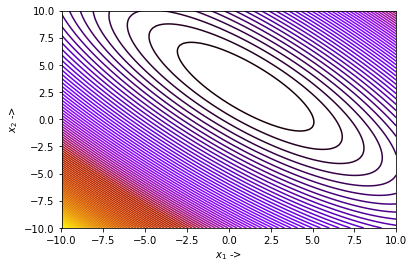

In [4]:
#plot the isolines
x1=np.linspace(-search_space,search_space,100)
x2=np.linspace(-search_space,search_space,100)

z=np.zeros(([len(x1),len(x2)]))

for i in range(len(x1)):
    for j in range (len(x2)):
        z[j,i]= booth([x1[i],x2[j]])

contours=plt.contour(x1,x2,z,100,cmap=plt.cm.gnuplot)
plt.xlabel("$x_1$ ->")
plt.ylabel("$x_2$ ->")
for x1,x2 in zip()


In [7]:
best.iloc[1]

nome                                            lbfgs
value                                         1.3e-16
iterations                                          5
func_eval                                          18
solutions     [0.9999999973095307, 2.999999997319014]
Name: 11, dtype: object